In [1]:
#!/usr/bin/env python
import sys
import zipfile
import urllib.request # requires Python 3
import io
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# Retracking 3D 

You can re-run the 3D tracking using new parameters using the following approach. If you select a specific frame range, you can also retrack with the original parameters to generate a small subset of data.

1. Install braid-offline (if not already installed): https://github.com/strawlab/strand-braid/releases/tag/braid%2F0.9.0
  * Download the tar.gz file, extract
  * Install: `sudo apt install PATH_TO_DEB_FILE`

2. May also want to install braid-cli, similar instructions as above

3. Check what the tracking parameters were for a given braidz file: `braidz-cli '/home/caveman/Downloads/20210109_180039.braidz'`

4. Create a toml file with new tracking parameters, e.g. `'~/offline_retracking_parameters.toml'`

```
motion_noise_scale= 0.1
initial_position_std_meters= 0.1
initial_vel_std_meters_per_sec= 1.0
ekf_observation_covariance_pixels= 6
accept_observation_min_likelihood= 1e-8
max_position_std_meters= 0.1
```

5. Learn the syntax of the command line call to retrack a braidz with different 3D tracking parameters: `offline-retrack --help`. For example: 
```bash
offline-retrack --tracking-params '~/offline_retracking_parameters.toml' --start-frame 560000 --stop-frame 561000 -d '~/20210109_180039.braidz' -o '~/20210109_180039_retracked.braidz'
```

# Helper functions

### Loading braidz data

In [2]:
def open_filename_or_url(filename_or_url):
    parsed = urllib.parse.urlparse(filename_or_url)
    is_windows_drive = len(parsed.scheme) == 1
    if is_windows_drive or parsed.scheme=='':
        # no scheme, so this is a filename.
        fileobj_with_seek = open(filename_or_url,mode='rb')
    else:
        # Idea for one day: implement HTTP file object reader that implements
        # seek using HTTP range requests.
        fileobj = urllib.request.urlopen(filename_or_url)
        fileobj_with_seek = io.BytesIO(fileobj.read())
    return fileobj_with_seek

def load_filename_as_dataframe_2d(filename_or_url, frame_range=None):
    fileobj = open_filename_or_url(filename_or_url)

    with zipfile.ZipFile(file=fileobj, mode='r') as archive:
        cam_info_df = pd.read_csv(
            archive.open('cam_info.csv.gz'),
            comment="#",
            compression='gzip')

        camn2camid = {}
        for i, row in cam_info_df.iterrows():
            camn2camid[row['camn']] = row['cam_id']

        cam_ids = list(cam_info_df['cam_id'].values)
        cam_ids.sort()
        data2d_distorted_df = pd.read_csv(
            archive.open('data2d_distorted.csv.gz'),
            comment="#",
            compression='gzip')
    
    if frame_range is None:
        return data2d_distorted_df
    else:
        return data2d_distorted_df.query('frame > ' + str(frame_range[0]) + \
                                         ' and frame < ' + str(frame_range[-1]))

def load_filename_as_dataframe_3d(filename_or_url, frame_range=None):
    fileobj = open_filename_or_url(filename_or_url)

    with zipfile.ZipFile(file=fileobj, mode='r') as archive:
        df = pd.read_csv(
            archive.open('kalman_estimates.csv.gz'),
            comment="#",
            compression='gzip')
    
    if frame_range is None:
        return df
    else:
        return df.query('frame > ' + str(frame_range[0]) + \
                        ' and frame < ' + str(frame_range[-1]))

### Filtering data using pandas groupby functions

In [19]:
def get_long_obj_ids_fast_pandas(df_3d, length=30):
    # This is much faster than other brute force methods. It leverages pandas stuff.
    number_frames_per_obj_id = df_3d[["frame", "obj_id"]].groupby(by=["obj_id"]).agg(["count"])
    long_obj_ids = number_frames_per_obj_id[  number_frames_per_obj_id[('frame', 'count')]  >  length  ].index.values
    return long_obj_ids

def get_middle_of_tunnel_obj_ids_fast_pandas(df_3d, zmin=0.1, zmax=0.4, ymin=-0.15, ymax=0.15):
    # only trajectories that are on average in the middle of the z dimension
    median_z = df_3d[["frame", "obj_id", "z"]].groupby(by=["obj_id"]).agg(["median"])
    obj_ids = median_z['z'].query('median > ' + str(zmin) + ' and median < ' + str(zmax) ).index.values
    
    df_3d_filtered = df_3d[df_3d.obj_id.isin(obj_ids)]
    
    # only trajectories that are on average in the middle of the y dimension
    median_y = df_3d_filtered[["frame", "obj_id", "y"]].groupby(by=["obj_id"]).agg(["median"])
    obj_ids = median_y['y'].query('median > ' + str(ymin) + ' and median < ' + str(ymax) ).index.values
    
    return obj_ids

### Plotting trajectories

In [4]:
def plot_3d_trajectory(df_3d, 
                       obj_ids=None,
                       frame_range=None,
                       mode='time', 
                       color=None,
                       xlim=[-0.5, 0.5], ylim=[-0.25, 0.25], zlim=[0, 0.5]):
    '''
    either obj_ids or frame_range must not be none
    
    obj_ids can be a list, in which case, multiple trajecs will be plotted
    frame_range should be a list with first and last frame of interest
    
    mode: 
       time = plot x,y,z,speed vs. time
       3d   = plot x vs y, x vs z
       
    '''
    if obj_ids is None:
        assert frame_range != None
        df_3d_q = df_3d.query('frame > ' + str(frame_range[0]) + ' and frame < ' + str(frame_range[-1]) )
        obj_ids = df_3d_q.obj_id.unique()
    
    try: 
        _ = obj_ids[0]
    except:
        obj_ids = [obj_ids]

    fig = plt.figure()
    
    # XY XZ planes
    if mode == '3d':
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for oid in obj_ids:
            trajec = df_3d[df_3d.obj_id==oid]
            ax1.plot(trajec.x, trajec.y)
            ax2.plot(trajec.x, trajec.z)

        for i, ax in enumerate([ax1, ax2]):
            ax.set_aspect('equal')
            ax.set_xlabel('x')
            if i == 0:
                ax.set_ylabel('y')
            else:
                ax.set_ylabel('z')
    
    # X,Y,Z,speed vs time
    elif mode == 'time':
        ax1 = fig.add_subplot(411)
        ax1.set_ylim(*xlim)
        ax1.set_ylabel('x pos')
        ax2 = fig.add_subplot(412)
        ax2.set_ylim(*ylim)
        ax2.set_ylabel('y pos')
        ax3 = fig.add_subplot(413)
        ax3.set_ylim(*zlim)
        ax3.set_ylabel('z pos')
        ax4 = fig.add_subplot(414)
        ax4.set_ylim(0, 1.5)
        ax4.set_ylabel('speed')
        ax4.set_xlabel('Frames')
        
        for oid in obj_ids:
            trajec = df_3d[df_3d.obj_id==oid]
            ax1.plot(trajec.frame, trajec.x)
            ax2.plot(trajec.frame, trajec.y)
            ax3.plot(trajec.frame, trajec.z)
            speed = np.sqrt(trajec.xvel**2 + trajec.yvel**2 + trajec.zvel**2)
            ax4.plot(trajec.frame, speed)
            
def plot_2d_data(df_2d, df_3d, frame_range=None):
    first_frame, last_frame = frame_range
    
    
    if first_frame is None:
        first_frame = df_2d.frame.values[0]
    if last_frame is None:
        last_frame = df_2d.frame.values[-1]
        
    frames = np.arange(first_frame, last_frame+1)
    df_3d_traj = df_3d[df_3d['frame'].isin(frames)]
    
    color = np.array([0.5]*len(frames))
    color[df_3d_traj.frame.values - frames[0]] = 1

    # get 2d data 
    df_2d_traj = df_2d[df_2d['frame'].isin(frames)]

    # Find all cameras
    camns = df_2d_traj.camn.unique()
    camns = np.sort(camns)

    # plot the data
    fig = plt.figure(figsize=(10,10))
    xticks = [first_frame, last_frame]
    for camn in camns:
        ax = fig.add_subplot(len(camns), 2, 2*camn+1)
        df_2d_traj_camn_frames = df_2d_traj[df_2d_traj['camn']==camn].frame.values
        ax.scatter( df_2d_traj[df_2d_traj['camn']==camn].frame, 
                    df_2d_traj[df_2d_traj['camn']==camn].x,
                    c=color[df_2d_traj_camn_frames-first_frame], vmin=0.5, vmax=1)
        ax.set_ylabel('Cam: ' + str(camn))

        # plot labels
        #ax.set_xlim(first_frame, last_frame)
        ax.set_xticks(xticks)
        ax.set_ylim(0, 800)
        ax.set_yticks([0, 800])
        if camn==0:
            ax.set_title('x pixel')
        if camn != camns[-1]:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Frames')

        ax = fig.add_subplot(len(camns), 2, 2*camn+2)
        ax.scatter(df_2d_traj[df_2d_traj['camn']==camn].frame, 
                   df_2d_traj[df_2d_traj['camn']==camn].y,
                   c=color[df_2d_traj_camn_frames-first_frame], vmin=0.5, vmax=1)

        # plot labels
        #ax.set_xlim(first_frame, last_frame)
        ax.set_xticks(xticks)
        ax.set_ylim(0, 800)
        ax.set_yticks([0, 800])
        if camn==0:
            ax.set_title('y pixel')
        if camn != camns[-1]:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Frames')

# Example data

### Load some of the original data and plot 3D trajec vs time

Original 3D tracking parameters:
```
motion_noise_scale= 0.1
initial_position_std_meters= 0.1
initial_vel_std_meters_per_sec= 1.0
ekf_observation_covariance_pixels= 1
accept_observation_min_likelihood= 1e-8
max_position_std_meters= 0.012
```

In [5]:
braid_file = '20210109_180039_original.braidz'
df_3d = load_filename_as_dataframe_3d(braid_file)

In [10]:
df_2d = load_filename_as_dataframe_2d(braid_file)

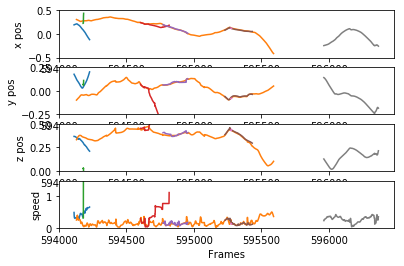

In [11]:
frame_range=[594000, 596500]
plot_3d_trajectory(df_3d, frame_range=frame_range)

### Load some retracked data, using more generous parameters

New tracking parameters:
```
motion_noise_scale= 0.1
initial_position_std_meters= 0.1
initial_vel_std_meters_per_sec= 1.0
ekf_observation_covariance_pixels= 6 # <--- changed
accept_observation_min_likelihood= 1e-8
max_position_std_meters= 0.1 # <--- changed
```

In [12]:
braid_file = '20210109_180039_retracked.braidz'
df_3d = load_filename_as_dataframe_3d(braid_file)

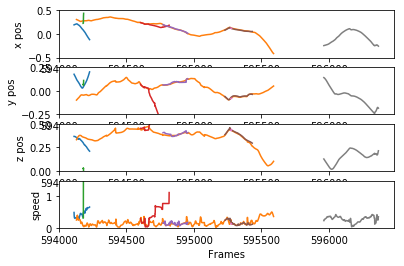

In [13]:
frame_range=[594000, 596500]
plot_3d_trajectory(df_3d, frame_range=frame_range)

##### Note: we now have a longer and more continuous trajectory. There are still some phantom trajectories, though.

### Plot the 2D data for the trajectories in the above time range

Yellow = there was 3D data (though not strictly corresponding to the 2d data that is plotted)

Purple = no 3D data

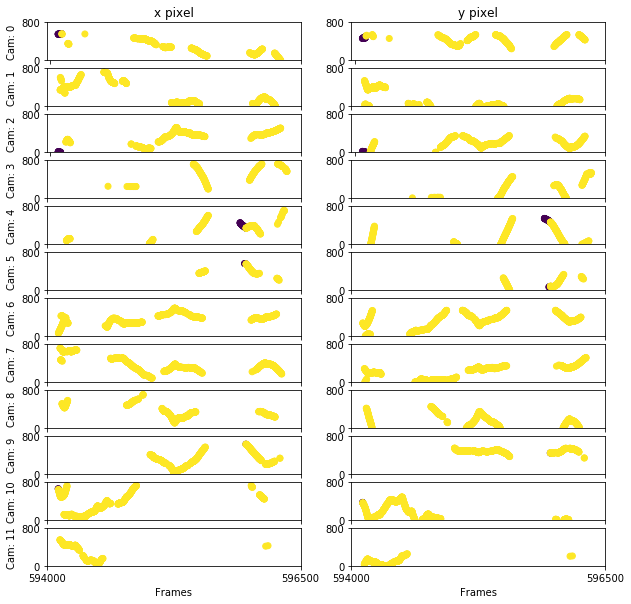

In [14]:
plot_2d_data(df_2d, df_3d, frame_range=frame_range)

### Filter out so we only have long trajectories that are roughly in the middle of the tunnel

In [15]:
# long object ids
long_obj_ids = get_long_obj_ids_fast_pandas(df_3d, length=300)
df_3d_filtered = df_3d[df_3d.obj_id.isin(long_obj_ids)]
print(long_obj_ids)

[ 25  28  38  39  44  49  50  51  62  64 134 140 148 149 150 153 154 175
 176 177 179 181 185 188 194 195 197 198 199 200 305]


In [20]:
# long object ids that are ALSO in middle of tunnel
middle_obj_ids = get_middle_of_tunnel_obj_ids_fast_pandas(df_3d_filtered)
df_3d_filtered = df_3d_filtered[df_3d_filtered.obj_id.isin(middle_obj_ids)]
obj_ids = df_3d_filtered.obj_id.unique()
print(obj_ids)

[ 28  38  44  49 194 195]


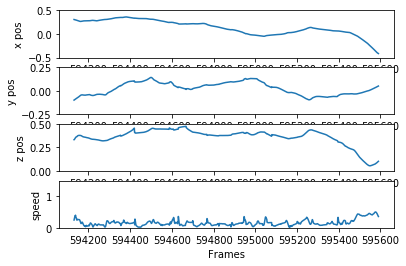

In [21]:
plot_3d_trajectory(df_3d_filtered, obj_ids[0])

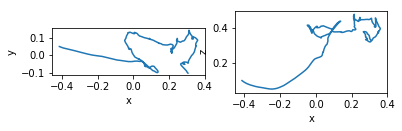

In [22]:
plot_3d_trajectory(df_3d_filtered, obj_ids[0], mode='3d')

# How many cameras contributed to a given portion of a trajectory?

In [54]:
def count_cameras_with_2d_data_for_frame(df_2d, frame):
    '''
    Find number of cameras that have 2d data for a given frame
    
    Could probably be made faster for many frames by using pandas groupby functions
    '''
    
    frames = np.arange(frame, frame+1)

    # get 2d data 
    df_2d_traj = df_2d[df_2d['frame'].isin(frames)]

    # Find all cameras
    camns = df_2d_traj.camn.unique()
    camns = np.sort(camns)

    # count cameras that have 2d data
    num_cams = len(camns) - sum( np.isnan( df_2d_traj.x.values ) )
    
    return num_cams

In [72]:
def get_trajec_and_num_cameras_with_2d_data_for_obj_id(df_2d, df_3d, obj_id):
    '''
    This assumes that all 2d data belongs to the 3d trajectory, 
    and that there is only one 3d trajectory at a time!
    
    This is kind of slow, because count_cameras_with_2d_data_for_frame is slow
    '''
    
    trajec = df_3d[df_3d.obj_id==obj_id]
    
    num_cams = [count_cameras_with_2d_data_for_frame(df_2d, frame) for frame in trajec.frame.values]
    
    return trajec, num_cams

In [73]:
obj_id = obj_ids[0]
trajec, num_cams = get_trajec_and_num_cameras_with_2d_data_for_obj_id(df_2d, df_3d, obj_id)

Text(0.5, 0, 'num cameras')

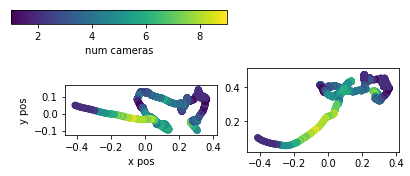

In [75]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_aspect('equal')

trajecplot = ax.scatter(trajec.x.values, trajec.y.values, c=num_cams)

ax.set_xlabel('x pos')
ax.set_ylabel('y pos')

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
trajecplot = ax2.scatter(trajec.x.values, trajec.z.values, c=num_cams)

cax = fig.add_axes([0, 0.8, 0.5, 0.05])
fig.colorbar(trajecplot, cax=cax, orientation='horizontal')
cax.set_xlabel('num cameras')

### In principle, you could use this approach to plot num_cameras vs. 3D location.

For example, given a 3D trajectory, use `get_trajec_and_num_cameras_with_2d_data_for_obj_id` to get trajec and num_cameras. Repeat for many trajectories.

Now you have a bunch of points that pair a 3D location and number of cameras. Do some kind of 3D interpolation to get a 3D volume of #cameras. 